### Hugging Face의 'transformers' 기반 번역 챗봇(ko to en)
- 모델은 OPUS-MT 프로젝트의 일부로 한영 번역 작업을 위해 사전 학습된 'Helsinki-NLP/opus-mt-ko-en' 사용
- AutoTokenizer: 이 클래스는 모델에 대한 텍스트 입력 전처리를 담당합니다. 텍스트를 토큰으로 분할하고, 모델에 필요한 특수 토큰을 추가하고, 토큰을 모델 어휘의 해당 ID로 변환하는 등 텍스트를 모델이 이해할 수 있는 형식으로 변환(토큰화)
- AutoModelForSeq2SeqLM: 이 클래스는 번역을 포함하는 시퀀스 간 언어 모델링에 적합한 모델 아키텍처를 로드합니다. 이 모델은 번역과 같은 작업에서 변환기가 작동하는 방식을 이해하는 데 기본이 되는 인코더-디코더 구조를 사용
-  KoreanToEnglishTranslator 인스턴스가 생성되면 지정된 model_name을 사용하여 토크나이저와 모델을 초기화
- 토큰화: 한국어 텍스트를 모델이 처리할 수 있는 형식으로 토큰화합니다. return_tensors="pt"는 출력이 PyTorch 텐서임을 나타내며 padding=True는 모든 시퀀스가 ​​동일한 길이로 채워지도록 보장
- 모델 생성: 'generate' 메소드가 모델 객체에서 호출됩니다. 이 방법은 인코더가 먼저 입력 시퀀스(한국어 텍스트)를 일련의 표현으로 인코딩하는 전체 시퀀스 간 생성 프로세스를 캡슐화합니다. 그런 다음 디코더는 이러한 표현을 사용하여 한 번에 하나의 토큰씩 출력 시퀀스(영어 번역)를 생성
- 디코딩: decode 메서드는 생성된 토큰 ID를 다시 읽을 수 있는 텍스트로 변환하고 처리에 사용된 특수 토큰을 생략




In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

class KoreanToEnglishTranslator:
    def __init__(self, model_name:str):
        """
        Initializes the translator model and tokenizer.
        Args:
        model_name: The name of the model to load from Hugging Face's model hub.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    def translate(self,text: str) -> str:
        """
        Translates Korean text to English.
        Args:
        text: The Korean text to translate.

        Returns:
        The translated English text.
        """
        inputs = self.tokenizer(text, return_tensors="pt", padding=True)

        outputs = self.model.generate(**inputs)

        translated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return translated_text

model_name = "Helsinki-NLP/opus-mt-ko-en" # Example model for Korean to English translation
translator = KoreanToEnglishTranslator(model_name)

korean_text = "인공지능 진화 속도가 아주 빠르네요"
english_translation = translator.translate(korean_text)
print(f"Korean Text: {korean_text}")
print(f"English Text: {english_translation}")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Korean Text: 인공지능 진화 속도가 아주 빠르네요
English Text: The rate at which artificial intelligence evolves is very rapid.


### Transformer의 핵심 구조
인코더(Encoder)와 디코더(Decoder)로 구성되어 있으며, 이를 통해 입력 문장을 인코딩하고 원하는 출력 문장을 디코딩합니다.

### 1. 인코더 (Encoder)
인코더는 입력 문장을 고차원 벡터로 변환하는 역할을 합니다. Transformer의 인코더는 여러 층의 **인코더 블록**으로 이루어져 있으며, 각 인코더 블록은 다음과 같은 구성 요소로 이루어져 있습니다.

- **멀티-헤드 셀프 어텐션 (Multi-Head Self-Attention):**
  셀프 어텐션(Self-Attention)은 문장의 각 단어가 다른 모든 단어와 어떻게 연관되는지를 계산하는 메커니즘입니다. 이를 통해 단어의 문맥을 이해하게 됩니다. 멀티-헤드 어텐션은 이를 여러 개의 병렬 처리된 어텐션 헤드로 나누어, 각각 다른 시각에서 어텐션을 수행하고, 그 결과를 종합하여 더 풍부한 정보를 얻습니다.

- **피드포워드 뉴럴 네트워크 (Feedforward Neural Network):**
  어텐션의 결과는 각 단어별로 개별적인 피드포워드 뉴럴 네트워크를 통과하여 추가적으로 처리됩니다. 이 네트워크는 일반적인 완전 연결층(Dense Layer)으로 구성됩니다.

- **정규화와 잔차 연결 (Layer Normalization and Residual Connection):**
  각 레이어는 정규화(Layer Normalization)와 잔차 연결(Residual Connection)을 통해 안정성을 높이고, 학습이 더 잘 되도록 합니다. 잔차 연결은 입력을 처리된 출력에 더해줌으로써 정보의 흐름을 원활하게 유지합니다.

여러 층의 인코더 블록을 거쳐 최종적으로 문장의 각 단어는 고차원의 벡터로 표현됩니다. 이 벡터는 단어 간의 관계를 잘 반영하며, 이후 디코더에 전달됩니다.

### 2. 디코더 (Decoder)
디코더는 인코더에서 전달받은 정보를 바탕으로 출력 문장을 생성하는 역할을 합니다. 디코더도 인코더와 유사한 구조를 가지지만, 몇 가지 중요한 차이점이 있습니다.

- **멀티-헤드 셀프 어텐션 (Multi-Head Self-Attention):**
  디코더의 셀프 어텐션은 인코더와 유사하지만, 현재 위치 이후의 단어 정보를 참조하지 못하게 하는 마스킹(Masking)이 추가됩니다. 이를 통해 디코더가 이전 단어들만 보고 다음 단어를 예측하게 됩니다.

- **인코더-디코더 어텐션 (Encoder-Decoder Attention):**
  디코더는 셀프 어텐션 외에도 인코더의 출력과의 어텐션 메커니즘을 가지고 있습니다. 이를 통해 입력 문장과의 연관성을 학습하고, 적절한 출력을 생성하게 됩니다. 이 단계에서는 인코더의 출력과 디코더의 현재 상태 간의 어텐션이 이루어집니다.

- **피드포워드 뉴럴 네트워크 (Feedforward Neural Network):**
  인코더와 마찬가지로, 어텐션 결과는 피드포워드 네트워크를 통과하여 처리됩니다.

최종적으로 디코더는 각 단어 위치에서 다음에 올 단어의 확률을 예측합니다. 이 확률을 바탕으로 단어를 하나씩 생성해 나가면서 최종 출력 문장을 완성합니다.

### 3. 전체 구조의 흐름
1. 입력 문장은 인코더에 의해 고차원 벡터로 변환됩니다.
2. 이 벡터는 디코더로 전달되어, 디코더는 이를 기반으로 출력 문장을 예측합니다.
3. 이 과정에서 어텐션 메커니즘을 통해 문맥을 잘 반영한 출력이 생성됩니다.

Transformer의 인코더-디코더 구조는 병렬 처리가 가능하고, 긴 문장에서도 효율적으로 문맥을 이해할 수 있어, 기존의 RNN이나 LSTM 기반 모델보다 우수한 성능을 보입니다.

### 입력 문장이 인코더에 의해 "고차원 벡터로 변환"
입력된 단어들이 고차원의 숫자 벡터로 표현된다는 것을 의미합니다. 이 과정은 임베딩(embedding)과 인코더 블록 내부의 처리 단계를 포함합니다.

### 1. 임베딩 (Embedding)
먼저, 입력 문장의 각 단어는 단어 임베딩 레이어를 통해 고차원 벡터로 변환됩니다. 임베딩이란, 단어를 고정된 크기의 실수 벡터로 변환하는 과정을 의미합니다. 예를 들어, 하나의 단어는 300차원의 벡터로 표현될 수 있습니다. 이 벡터는 해당 단어의 의미적 특성을 담고 있으며, 비슷한 의미의 단어들은 유사한 벡터 값을 가지게 됩니다. 이 단계에서 "고차원"이란 일반적으로 수백 차원의 벡터를 의미합니다.

### 2. 인코더 블록의 변환
임베딩된 벡터는 인코더 블록을 통해 추가적으로 처리됩니다. 인코더 블록은 어텐션 메커니즘과 피드포워드 뉴럴 네트워크를 통해 단어 간의 관계와 문맥을 반영하여 벡터를 더욱 정교하게 변환합니다.

- **멀티-헤드 셀프 어텐션:** 단어 임베딩 벡터는 셀프 어텐션 메커니즘을 통해 서로 간의 연관성을 고려한 새로운 벡터로 변환됩니다. 이 과정에서 문장 내의 다른 단어들과의 상호작용이 반영되어 각 단어의 의미가 문맥에 따라 조정됩니다.

- **피드포워드 뉴럴 네트워크:** 어텐션 결과는 피드포워드 네트워크를 통과하며, 이 과정에서 벡터의 차원이 변하거나 (주로 유지되지만) 더욱 비선형적인 변환이 이루어집니다. 이를 통해 문장의 각 단어 벡터는 문맥 정보가 포함된 고차원 벡터로 재구성됩니다.

이 과정이 인코더의 여러 층을 통해 반복되면서, 입력 문장은 문맥과 의미가 풍부하게 반영된 고차원 벡터로 점진적으로 변환됩니다.

### 요약
- **임베딩** 단계에서는 단어가 고차원 벡터로 변환됩니다.
- **인코더 블록**에서는 이 벡터들이 어텐션과 피드포워드 네트워크를 통해 문맥을 반영한 더 정교한 고차원 벡터로 변환됩니다.

따라서, "고차원 벡터로 변환"된다는 것은 단어들이 단순히 임베딩된 벡터뿐만 아니라, 문장의 전체적인 문맥과 의미를 반영한 벡터 표현으로 재구성된다는 것을 의미합니다. 이 벡터들은 이후 디코더에서 사용되어 출력 문장을 생성하는 데 중요한 역할을 합니다.

### 임베딩 벡터의 차원 vs. vocab 사전(단어 사전, 어휘 사전, vocabulary)


### 1. Vocab 사전 (Vocabulary)
- **Vocab 사전이란?**: Vocab 사전은 모델이 처리할 수 있는 단어들의 목록입니다. 이 사전은 훈련 데이터에 나타나는 모든 단어들(또는 가장 빈도가 높은 단어들)을 포함하며, 각 단어에는 고유한 인덱스가 부여됩니다. 예를 들어, "the", "cat", "sat" 같은 단어들이 있다면, 각 단어는 vocab 사전에서 특정 인덱스에 해당합니다.

- **어휘 크기 (Vocabulary Size):** 사전에 포함된 단어의 총 수를 의미합니다. 예를 들어, vocab 사전의 크기가 10,000이라면, 모델은 10,000개의 단어를 인식하고 처리할 수 있습니다.

### 2. 임베딩 벡터와 Vocab 사전의 관계
- **임베딩 행렬:** 임베딩 레이어는 각 단어를 고차원 벡터로 변환하는 역할을 합니다. 이 과정에서 사용하는 것이 바로 **임베딩 행렬**입니다. 이 행렬의 크기는 `Vocab 크기 x 임베딩 차원`으로 정의됩니다. 예를 들어, vocab 크기가 10,000이고 임베딩 차원이 300이라면, 임베딩 행렬의 크기는 10,000 x 300이 됩니다.

- **단어 벡터화:** 임베딩 행렬의 각 행(row)은 vocab 사전의 특정 단어에 해당하는 벡터입니다. 예를 들어, "cat"이라는 단어가 vocab 사전에서 2번째 인덱스에 있다면, 임베딩 행렬의 2번째 행이 "cat"의 임베딩 벡터를 나타냅니다. 이 벡터는 `300`개의 숫자로 구성될 수 있습니다(만약 임베딩 차원이 300이라면).

### 3. 관계 요약
- **Vocab 크기와 차원:** Vocab 사전의 크기는 단어의 수를 나타내며, 이는 임베딩 행렬의 행 수를 결정합니다. 반면, 벡터 차원은 각 단어를 표현하는 벡터의 크기를 나타내며, 이는 임베딩 행렬의 열 수를 결정합니다.

- **인코딩 과정:** 입력 문장이 주어지면, 각 단어는 vocab 사전에서 해당 인덱스를 찾고, 그 인덱스에 해당하는 임베딩 벡터를 가져옵니다. 이 벡터가 인코딩 과정의 시작점이 됩니다.

- **임베딩 차원 vs. Vocab 크기:** 두 개념은 독립적이지만, 임베딩 차원은 모델의 표현력을 결정하고, vocab 크기는 모델이 처리할 수 있는 단어 범위를 결정합니다. 일반적으로 더 큰 vocab 사전은 더 많은 단어를 처리할 수 있지만, 그만큼 더 큰 임베딩 행렬을 필요로 하며, 계산 비용이 증가할 수 있습니다.

### 4. 실용적인 고려사항
- **OOV(Out-of-Vocabulary):** Vocab 사전에 없는 단어들은 모델이 처리할 수 없기 때문에, 일반적으로 "OOV" 토큰으로 처리됩니다. 이 토큰도 임베딩 벡터를 가집니다.
- **임베딩 차원 조정:** 임베딩 차원은 학습할 단어의 복잡성에 따라 조정됩니다. 예를 들어, 단순한 작업에서는 50~100차원으로 충분할 수 있지만, 복잡한 언어 모델에서는 300차원 이상을 사용할 수 있습니다.

Vocab 사전은 단어와 임베딩 벡터를 연결하는 역할을 하며, 각 단어를 고차원 벡터로 표현하기 위해 사용됩니다. 임베딩 차원은 각 단어 벡터의 크기를 나타내며, vocab 사전의 크기와 함께 임베딩 행렬의 크기를 결정합니다. 이 두 요소는 모델의 성능과 계산 효율성에 중요한 영향을 미칩니다.

### 트랜스포머 블록
- 인코더와 디코더 블록의 구조는 디테일에서 차이가 있을 뿐 본질적으로는 크게 다르지 않다.
- 멀티 헤드 어텐션, 피드포워드 뉴럴 네트워크, 잔차 연결 및 레이어 정규화 등 세 가지 구성 요소를 기본

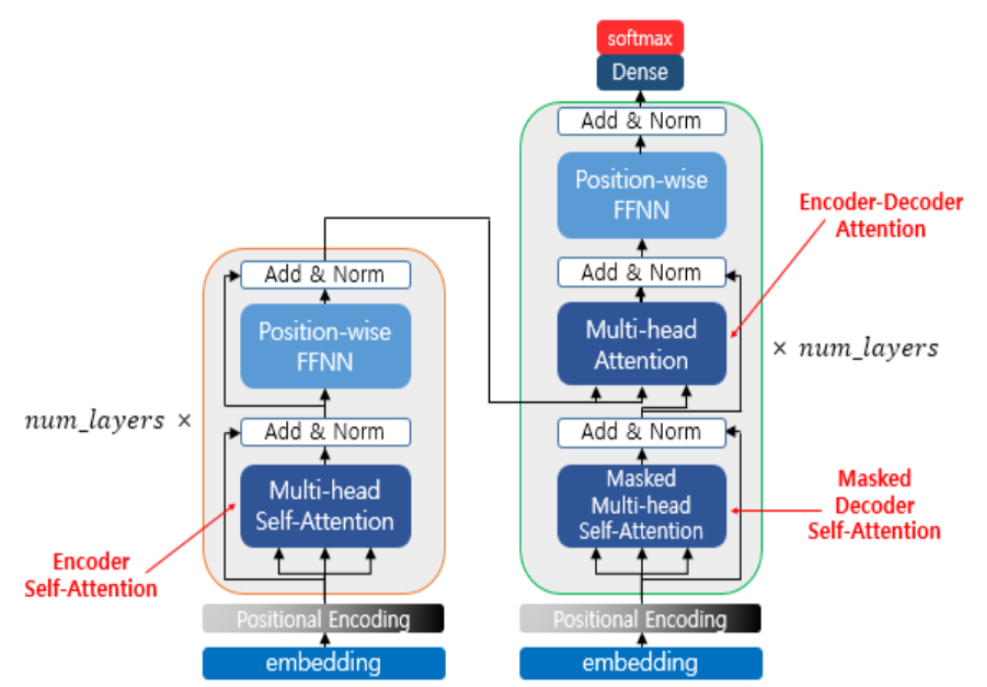

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/kdt_240424/m7_nlp응용/data/self.png',width=900,height=600)

## Self-attention 메커니즘
이 메커니즘은 입력된 각 단어가 다른 모든 단어와 얼마나 관련 있는지를 계산하는 과정에서 **질의(query)**, **키(key)**, 그리고 **값(value)** 세 가지 요소를 활용합니다.

### 1. Self-Attention의 기본 개념
Self-attention은 시퀀스 내의 각 단어가 같은 시퀀스 내의 다른 단어들과의 관계를 학습하는 메커니즘입니다. 이 메커니즘은 주로 다음과 같은 단계로 구성됩니다:
1. **질의(Query), 키(Key), 값(Value) 벡터 생성**
2. **유사도(Attention Score) 계산**
3. **어텐션 가중치 계산**
4. **가중치 적용 후 출력 벡터 생성**

이 과정에서 질의, 키, 값은 입력된 단어 임베딩에서 파생된 벡터입니다.

### 2. 질의(Query), 키(Key), 값(Value) 벡터 생성
Transformer에서 Self-attention을 수행할 때, 입력 시퀀스의 각 단어는 고차원 벡터로 표현됩니다. 이 벡터들로부터 **질의(Query)**, **키(Key)**, **값(Value)** 벡터가 각각 생성됩니다.

- **단어 임베딩 (Word Embedding):** 입력 문장의 각 단어는 임베딩 레이어를 거쳐 고차원 벡터로 변환됩니다. 예를 들어, 각 단어가 512차원 벡터로 표현될 수 있습니다.
  
- **선형 변환 (Linear Transformation):** 임베딩된 벡터는 세 개의 다른 가중치 행렬 $W_Q, W_K, W_V$를 사용하여 각각 질의, 키, 값 벡터로 변환됩니다.

  $Q = X \cdot W_Q$<br>
  $K = X \cdot W_K$<br>
  $V = X \cdot W_V$

  여기서 \(X\)는 입력 임베딩 벡터이고, $W_Q, W_K, W_V$는 학습 가능한 가중치 행렬입니다.

  이 변환은 질의, 키, 값 벡터가 각각 다른 특징 공간에서 특정 역할을 수행할 수 있도록 합니다. 이 벡터들은 보통 동일한 차원(예: 512차원)으로 설정되지만, 모델에 따라 다를 수 있습니다.

### 3. 유사도(Attention Score) 계산
질의 벡터와 키 벡터는 유사도를 계산하여 각 단어 간의 관계를 파악하는 데 사용됩니다.

- **점곱 (Dot Product):** 질의 벡터 \(Q_i\)와 모든 키 벡터 \(K_j\) 간의 점곱을 계산하여 유사도를 구합니다.

  $\text{Score}(Q_i, K_j) = Q_i \cdot K_j^T$

  이 점곱 결과는 특정 단어 $i$가 문장 내의 다른 단어 $j$와 얼마나 관련 있는지를 나타냅니다. 점곱이 크면 두 단어가 관련이 많음을 의미합니다.

- **스케일링 (Scaling):** 계산의 안정성을 위해, 이 점곱 값들을 키 벡터의 차원 크기의 제곱근으로 나누어 줍니다.

  $\text{Score}(Q_i, K_j) = \frac{Q_i \cdot K_j^T}{\sqrt{d_k}}$

  여기서 $d_k$는 키 벡터의 차원입니다.

### 4. 어텐션 가중치 계산
- **소프트맥스 (Softmax):** 계산된 유사도 점수를 소프트맥스(Softmax) 함수에 통과시켜 각 단어와 관련된 가중치(확률 분포)를 계산합니다.

  $\alpha_{ij} = \text{Softmax}\left(\frac{Q_i \cdot K_j^T}{\sqrt{d_k}}\right)$
  
  이 가중치는 단어 $i$가 다른 단어 $j$와 얼마나 관련이 있는지를 나타내는 확률값입니다. 모든 가중치의 합은 1이 됩니다.

### 5. 가중치 적용 후 출력 벡터 생성
- **값(Value) 벡터의 가중합:** 계산된 어텐션 가중치 $\alpha_{ij}$를 각 값(Value) 벡터 $V_j$에 곱한 후, 이들의 가중합을 계산하여 최종 출력 벡터를 생성합니다.

  $\text{Attention Output} = \sum_{j} \alpha_{ij} V_j$

  이 과정은 단어 $i$에 대해 관련성이 높은 단어들의 값 벡터를 가중평균하여 새로운 벡터 표현을 만드는 것입니다.

### 요약
- **질의(Query) 벡터**: 특정 단어가 다른 단어와 얼마나 관련이 있는지를 "질문"하는 역할을 합니다.
- **키(Key) 벡터**: 각 단어의 특징을 나타내며, 다른 단어의 질의와 얼마나 "매칭"되는지를 계산합니다.
- **값(Value) 벡터**: 최종 출력에 사용될 정보를 담고 있으며, 계산된 어텐션 가중치에 따라 가중합되어 출력 벡터를 만듭니다.

Self-attention 메커니즘은 이 질의-키-값 벡터의 조합을 통해 입력 문장의 단어들이 서로 간에 어떻게 관련되는지 학습하고, 이를 바탕으로 문맥을 고려한 단어 표현을 생성합니다. 이 과정이 Transformer 모델에서 강력한 문맥 이해와 병렬 처리 능력을 제공하는 핵심 요소입니다.

## 멀티헤드 어텐션(Multi-Head Attention)
Transformer 모델에서 중요한 구성 요소로, 단일 어텐션 메커니즘을 여러 번 반복하여 다양한 관점에서 입력 데이터의 관계를 학습할 수 있도록 한 것입니다. 이 메커니즘은 특히 자연어 처리(NLP) 작업에서 문장의 문맥을 더 풍부하게 이해하는 데 큰 기여를 합니다.

### 1. 멀티헤드 어텐션의 구조
멀티헤드 어텐션은 기본 어텐션 메커니즘을 병렬로 여러 번 적용하여, 다양한 표현을 학습할 수 있도록 합니다. 이를 위해, 여러 개의 **헤드(head)**가 사용됩니다.

- **헤드 (Head):** 하나의 헤드는 기본 어텐션 메커니즘을 한 번 실행하는 것을 의미합니다. 각 헤드는 입력된 임베딩 벡터를 독립적으로 질의, 키, 값 벡터로 변환한 후, 어텐션을 계산하여 각각의 출력 벡터를 생성합니다.

- **여러 개의 헤드:** 멀티헤드 어텐션에서는 이러한 헤드가 여러 개 존재합니다(예: 8개 또는 12개). 각 헤드는 고유한 가중치 행렬 $W_Q, W_K, W_V$를 사용하여 입력 벡터를 다른 방식으로 변환합니다. 이로 인해 동일한 입력에 대해 각 헤드가 서로 다른 방식으로 어텐션을 계산하게 됩니다.

- **차원 축소 및 확장:** 각 헤드는 전체 임베딩 차원의 일부만 사용하여 질의, 키, 값 벡터를 생성할 수 있습니다. 예를 들어, 입력 임베딩이 512차원이고 8개의 헤드를 사용하는 경우, 각 헤드는 512/8 = 64차원으로 줄여진 벡터에서 어텐션을 계산할 수 있습니다.

- **헤드 병합 및 선형 변환:** 각 헤드가 계산한 어텐션 출력은 최종적으로 하나로 병합(concatenate)되며, 병합된 벡터는 다시 선형 변환(fully connected layer)을 통해 최종 출력 벡터로 변환됩니다.

### 2. 멀티헤드 어텐션의 작동 원리

1. **입력 임베딩 분할:** 입력 임베딩을 여러 개의 헤드로 분할합니다. 각 헤드는 자신의 질의, 키, 값 벡터를 생성합니다.

2. **각 헤드에서 어텐션 계산:** 각 헤드는 독립적으로 어텐션 메커니즘을 실행하여 출력 벡터를 생성합니다. 이 과정에서 각 헤드는 입력 데이터를 다양한 관점에서 처리합니다. 예를 들어, 한 헤드는 문장의 문법적 관계에 집중할 수 있고, 다른 헤드는 단어 간의 의미적 유사성에 집중할 수 있습니다.

3. **헤드 병합:** 각 헤드에서 생성된 출력 벡터를 하나로 병합(concatenate)하여 큰 하나의 벡터로 만듭니다.

4. **선형 변환:** 병합된 벡터에 선형 변환을 적용하여 최종 출력 벡터를 생성합니다. 이 출력 벡터는 입력 문장 내의 각 단어가 다른 단어들과의 다양한 관계를 반영한 벡터로서, 모델의 다음 층에 전달됩니다.

### 3. 멀티헤드 어텐션의 장점
- **다양한 관계 포착:** 멀티헤드 어텐션은 입력 데이터의 다양한 관점을 학습할 수 있어, 단일 어텐션보다 훨씬 더 풍부한 문맥 정보를 캡처할 수 있습니다.
- **복잡한 패턴 학습:** 여러 헤드를 사용함으로써 모델은 복잡한 패턴이나 다중 의미를 더 잘 학습할 수 있습니다. 예를 들어, "bank"라는 단어가 한 문장에서 금융기관을 의미할 때와 강둑을 의미할 때의 차이를 더 잘 포착할 수 있습니다.

멀티헤드 어텐션은 여러 개의 어텐션 메커니즘을 병렬로 적용하여, 각기 다른 관점에서 입력 데이터를 분석하고, 이를 종합하여 더욱 풍부한 문맥 정보를 담은 출력을 생성하는 방법입니다. 이 구조는 Transformer 모델이 매우 강력한 문맥 이해 능력을 갖추게 하는 핵심 요소 중 하나입니다.

이 코드는 PyTorch를 사용하여 Self-Attention 메커니즘의 핵심 개념을 구현한 것입니다. 이 코드에서는 입력된 시퀀스 데이터로부터 쿼리(Query), 키(Key), 값(Value) 벡터를 생성하고, 이를 이용해 어텐션 스코어를 계산한 후, 소프트맥스(Softmax)를 적용하여 최종적으로 가중합된 출력을 생성하는 과정을 수행

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

x = torch.tensor([
  [1.0, 0.0, 1.0, 0.0],
  [0.0, 2.0, 0.0, 2.0],
  [1.0, 1.0, 1.0, 1.0],
])
w_query = torch.tensor([
  [1.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 1.0]
])
w_key = torch.tensor([
  [0.0, 0.0, 1.0],
  [1.0, 1.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 1.0, 0.0]
])
w_value = torch.tensor([
  [0.0, 2.0, 0.0],
  [0.0, 3.0, 0.0],
  [1.0, 0.0, 3.0],
  [1.0, 1.0, 0.0]
])

# 쿼리, 키, 값 벡터 생성 : 입력 데이터 x에 대해 각 w_query, w_key, w_value가중치 행렬을 곱하여 쿼리, 키 , 값으로 변환
queries = torch.matmul(x, w_query) # 쿼리는 현재 초점을 맞추고 데이터의 일부를 나타낸다
keys = torch.matmul(x, w_key) # 키는 관련성을 확인하기 위해 쿼리가 상호 작용하는 데이터 부분에 해당
values = torch.matmul(x, w_value) # 값은 쿼리와의 관련성에 따라 출력에 사용될 데이터의 실제 정보를 전달

# 어텐션 스코어 계산 : 어텐션 스코어는 입력 시퀀스의 여러  부분 간의 관련성을 측정
# 쿼리 행렬에 키 행렬(keys.T)의 전치를 곱하면 문장의 다른 모든 단어에 대한 모든 단어의 관련성을 나타내는 점수 집합이 계산
attn_scores = torch.matmul(queries, keys.T)

print(keys.shape)
np.sqrt(keys.shape[-1])

# 스코어 정규화 : 특정 단어가 각 단어에 얼마나 가중치를 둘 것인가를 계산, 모든 키에 대한 스코어 합이 1이 되도록함
key_dim_sqrt = np.sqrt(keys.shape[-1]) # 키 벡터의 차원 크기의 제곱근, 어텐션 스코어가 지나치게 커지는 것을 방지하기 위해 사용
# 소프트 맥스 함수 : 마지막 차원(dim=01)을 따라 조정된 어텐션 스코어에 적용되어 이를 확률로 변환
# 소프트 맥스 함수를 적용한 어텐션 스코어로, 각 단어의 다른 단어와의 관계를 나타내는 확률 분포
attn_scores_softmax = F.softmax(attn_scores/ key_dim_sqrt, dim=-1)

# 가중합 계산 : 정규화된 스코어를 각 값 벡터에 곱한 후, 모두 합하여 새로운 벡터를 생성하여 쿼리 단어의 문맥을 반영한 표현을 생성
weighted_values = torch.matmul(attn_scores_softmax, values)
weighted_values

torch.Size([3, 3])


tensor([[1.8639, 6.3194, 1.7042],
        [1.9991, 7.8141, 0.2735],
        [1.9926, 7.4796, 0.7359]])

### 피드포워드 뉴럴네트워크 계산
- 멀티 헤드 어텐션의 출력은 입력 단어들에 대응하는 벡터 시퀀스이며 이후 벡터 각각을 피드포워드 신경망(FFNN)에 입력한다.

In [ ]:
import torch
# x 입력 w1은 입력층-은닉층을 연결하는 가중치, b1은 입력층-은닉층을 연결하는 바이어스
# w2는 은닉층-출력층을 연결하는 가중치, b2는 은닉층-출력층을 연결하는 바이어스
x = torch.tensor([2,1])
w1 = torch.tensor([[3,2,-4],[2,-3,1]])
b1 = 1
w2 = torch.tensor([[-1,1],[1,2],[3,1]])
b2 = -1

# 입력 데이터 x를 받아 두 번의 선형 변환과 ReLU 활성화 함수를 통과시켜 최종 출력  y를 생성하는 피드포워드 신경망
h_preact = torch.matmul(x,w1) +b1
h = torch.nn.functional.relu(h_preact)
y = torch.matmul(h,w2) +b2

In [ ]:
print(x, x.shape)
print(w1, w1.shape)
print(h, h.shape)
print(w2,w2.shape)
print(y, y.shape)

tensor([2, 1]) torch.Size([2])
tensor([[ 3,  2, -4],
        [ 2, -3,  1]]) torch.Size([2, 3])
tensor([9, 2, 0]) torch.Size([3])
tensor([[-1,  1],
        [ 1,  2],
        [ 3,  1]]) torch.Size([3, 2])
tensor([-8, 12]) torch.Size([2])


### 잔차 연결
- 블록(block) 계산을 건너뛰는 경로를 하나 두는 것
- 입력을  x, 이번 계산 대상 블록을  F 라고 할 때 잔차 연결은  F(x)+x 로 간단히 실현
- 딥러닝 모델은 레이어가 많아지면 학습이 어려운 경향이 있는데 모델을 업데이트하기 위한 신호(그래디언트)가 전달되는 경로가 길어지기 때문이다. 잔차 연결은 그래디언트가 직접적으로 더 앞 단의 레이어로 흐를 수 있는 '지름길'을 제공하여 역전파 시 그래디언트 소실 문제를 완화하는 데 도움을 줍니다.

### 레이어 정규화
- 레이어 정규화는 각 층의 활성화 출력을 정규화하여 학습 도중 각 층의 입력 분포가 크게 바뀌는 것을 방지
- 레이어 정규화는 각 층의 출력을 독립적으로 정규화. 한 층의 출력이 정규화되는 것이 다른 층의 출력에 영향을 미치지 않는다.
- 각 서브레이어(셀프 어텐션과 피드 포워드 신경망)의 출력에 레이어 정규화를 적용하고, 이를 잔차 연결과 결합하여 최종 출력을 생성


- 일반적으로 표본이 추출된 모집단의 분산에 대한 정확한 추정치를 제공하는 불편 추정량을 위하여 평균과의 제곱된 편차의 합을 'n' 대신 'n-1'로 나눔으로써 달성하는 반면
- 신경망과 배치 정규화의 맥락에서는 목표가 약간 다른 경우가 많습니다. 모집단 분산에 대한 편견 없는 추정치를 얻는 것이 아니라 훈련 과정을 안정화하고 가속화하는 데 중점을 둡니다. 이러한 맥락에서 편향된 분산를 사용하는 것(즉, n-1 대신 n으로 나누는 것)은 다음과 같은 몇 가지 이유로 더 바람직할 수 있습니다.
  - 효율성: 편향된 분산 추정기를 사용하면 분모에서 추가 빼기 연산을 방지하므로 계산이 더 간단하고 약간 더 빨라질 수 있습니다.
  - 안정성: 신경망 훈련 설정, 특히 미니 배치의 경우 'n-1' 대신 'n'을 사용함으로써 발생하는 약간의 편향은 더 안정적이고 더 빠른 수렴.
  - 규모: 신경망은 일반적으로 대규모 데이터 세트와 여러번에 걸쳐 훈련됩니다. 즉, 더 많은 데이터가 처리됨에 따라 분산 추정의 편향 효과가 줄어듭니다.

이 코드는 미니 배치 정규화(Batch Normalization)의 개념을 간단하게 구현한 것입니다. 이 과정에서는 입력 데이터의 각 인스턴스(여기서는 입력 텐서의 각 행)를 정규화하고, 그 후 학습 가능한 가중치인 gamma와 beta를 사용하여 출력값을 조정합니다.

In [ ]:
# 미니 배치의 인스턴스(x)별로 평균을 빼주고 표준편차로 나누어 정규화를 수행하는 기법
# gamma와 β는 학습 과정에서 업데이트되는 가중치
import torch

# 정규화될 입력 데이터
input_tensor = torch.tensor([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]])

# 'eps'(엡실론)는 0으로 나누는 것을 방지하여 수치 안정성을 보장하기 위해 정규화 중에 분산에 추가되는 작은 숫자
eps = 1e-5

# 각 입력 벡터(마지막 차원 전체, dim=-1)의 평균과 분산이 계산
# keepdim=True 매개변수는 결과 평균 및 분산 텐서가 input_tensor와 동일한 수의 차원을 유지하도록 보장하여 후속 작업을 용이하게 합니다.
# unbiased=False는 분산 계산에서 Bessel의 보정(자유도 보정)을 적용하지 않음을 의미합니다.
mean = input_tensor.mean(dim=-1, keepdim=True)
variance = input_tensor.var(dim=-1, keepdim=True, unbiased=False)

# 정규화: 입력 텐서의 각 요소에서 해당 인스턴스의 평균을 빼고, 그 결과를 해당 인스턴스의 표준편차(분산의 제곱근)로 나누어 정규화를 수행합니다.
# eps: variance에 매우 작은 값을 더하는데, 이는 나눗셈에서 0으로 나누는 상황을 방지하기 위해서입니다. 이 값(1e-5)은 수치적 안정성을 보장합니다
normalized_input = (input_tensor - mean) / torch.sqrt(variance + eps)

# 최종 출력은 정규화된 입력을 '감마'로 스케일링한 다음 이를 '베타'만큼 이동
# gamma: 정규화된 입력에 곱해질 스케일링 파라미터입니다. 이 파라미터는 학습 가능한 값으로, 정규화된 데이터를 조정할 수 있게 합니다. 여기서는 1로 초기화되어 있습니다.
# beta: 정규화된 입력에 더해질 시프트 파라미터입니다. 이 역시 학습 가능한 값으로, 초기에는 0으로 설정되어 있습니다.
# gamma를 1로, beta를 0으로 초기화하면 정규화된 데이터를 변경하지 않고 훈련 프로세스가 시작되므로 모델이 최적의 조정을 학습할 수 있는 중립 시작점이 제공
gamma = torch.ones(input_tensor.shape[-1])
beta = torch.zeros(input_tensor.shape[-1])

output = gamma * normalized_input + beta

print(output)

tensor([[-1.2247,  0.0000,  1.2247],
        [ 0.0000,  0.0000,  0.0000]])


Layer Normalization (레이어 정규화)
- 정규화 범위: 레이어 정규화는 입력 데이터의 각 **특징(feature)**에 대해 정규화를 수행합니다. 즉, 각 인스턴스(예: 한 샘플 또는 미니 배치의 한 항목)별로 독립적으로 정규화를 수행합니다. 입력 텐서의 마지막 차원(특징 차원) 전체에서 평균과 분산을 계산합니다.

- 적용 방식: 입력 데이터의 모든 특징에 대해 평균과 분산을 계산하고, 이를 사용하여 정규화를 수행합니다. 레이어 정규화는 미니 배치의 크기에 독립적이기 때문에, RNN이나 트랜스포머(Transformer) 같은 모델에서 유용하게 사용됩니다. 이 경우, 미니 배치의 크기에 상관없이 동일한 방식으로 정규화가 이루어집니다.

- 적용 위치: 레이어 정규화는 주로 RNN, 트랜스포머 모델에서 사용됩니다. 이는 시퀀스 모델에서 샘플별로 정규화가 필요할 때 특히 유용합니다.

m = torch.nn.LayerNorm(input.shape[-1])
- 레이어 정규화 모듈을 초기화하여 PyTorch는 자동으로 weight와 bias라는 두 가지 중요한 매개변수를 생성합니다. 이러한 매개변수는 정규화 프로세스의 일부이며 신경망 훈련 중에 최적화됩니다.
- 입력 값은 각 데이터 포인트의 특성 전체에 걸쳐 평균 0과 표준 편차 1을 갖도록 정규화된 후 'm.weight'에 따라 크기가 조정됩니다. 이 스케일링은 요소별 곱셈입니다.
- m.weight로 정규화된 값을 스케일링한 후 m.bias가 결과에 추가됩니다. 이러한 바이어스 추가를 통해 손실 함수를 최소화하는 데 도움이 되는 경우 레이어가 정규화 및 스케일링된 값을 이동할 수 있습니다. 이 단계를 통해 계층 정규화 계층은 네트워크 성능에 유리한 방식으로 출력 분포를 조정할 수 있습니다.

In [ ]:
# 각 데이터 포인트(입력 텐서의 각 벡터)에 대해 LayerNorm은 평균이 0이고 표준 편차가 1이 되도록 특성을 정규화
import torch
input = torch.tensor([[1.0,2.0,3.0],[1.0,1.0,1.0]])
m = torch.nn.LayerNorm(input.shape[-1]) # 각 데이터 포인트 내의 모든 특성에 대해 평균과 분산을 계산
output = m(input)
output

tensor([[-1.2247,  0.0000,  1.2247],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
# weight를 1로 초기화 파라미터 학습 과정에서 역전팔르 통해 갱신되며, 이는 모델이 데이터에 가장 적합한 스케일과 평균을 학습
m.weight

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)

In [ ]:
# bias를 0으로 치고하. 파라미터는 학습 과정에서 역전파를 통해 갱신되며, 이는 모델이 데이터에 가장 적합한 스케일과 평균을 학습
m.bias

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

### 드롭아웃
- 딥러닝 모델은 그 표현력이 아주 좋아서 학습 데이터 그 자체를 외워버릴 염려가 있으며 이를 과적합(overfitting)이라고 한다.
- 드롭아웃(dropout)은 이러한 과적합 현상을 방지하고자 뉴런의 일부를 확률적으로 0으로 대치하여 계산에서 제외하는 기법

In [ ]:
import torch
m = torch.nn.Dropout(p=0.2)
input = torch.randn(1,10)
output = m(input)

In [ ]:
input

tensor([[ 1.4725,  0.4149,  0.9644,  0.9656, -1.4650,  0.9917,  0.1387,  0.1092,
         -0.5729, -0.8147]])

In [ ]:
output

tensor([[ 1.8406,  0.5186,  1.2055,  0.0000, -1.8312,  1.2396,  0.1734,  0.1365,
         -0.7161, -1.0184]])

###  파이토치(PyTorch)를 사용하여 영화 리뷰의 감정(긍정적 또는 부정적)을 분류하는 트랜스포머 기반 모델을 훈련하는 과정 - 소량 데이터 셋으로 모델링
Q. 아래 영화 reviews 및 label 데이터에 대하여 PyTorch의 Transformer 모델을 사용하여 단순화된 텍스트 분류 작업을 구현하세요.

reviews = ["I loved the movie!", "It was a fantastic film.", "Terrible movie, I hated it.", "The plot was boring.", "What a great performance!"]

labels = torch.tensor([1, 1, 0, 0, 1])

1단계: 데이터 세트 준비
- MovieReviewDataset 클래스: torch.utils.data.Dataset의 이 하위 클래스 모델에 대한 영화 리뷰 데이터를 준비
- tokenizer 및 build_vocab: torchtext의 토크나이저는 리뷰를 토큰으로 분할하는 데 사용. build_vocab_from_iterator는 토큰화된 리뷰로부터 어휘를 구축하여 각 고유 토큰을 정수 인덱스에 매핑
- 리뷰 및 라벨: 영화 리뷰와 해당 감정 라벨(긍정적 1, 부정적 0)을 나타내는 예제 데이터
- 트랜스포머의 학습 방식에서 자기 지도 학습 방법과 지도 학습 방법 사이의 선택은 훈련의 특정 목표와 사용 가능한 데이터의 특성에 따라 달라집니다.

2단계: 분류를 위한 변환기 모델 정의
- TransformerClassifier 클래스: 이 신경망 모델은 분류 작업을 위한 Transformer 아키텍처를 캡슐화
  - 클래스는 임베딩 층, 트랜스포머 인코더 층, 그리고 최종 분류를 위한 선형 층으로 구성됩니다.
  - 입력 텍스트는 먼저 임베딩 층을 통과하여 고차원 벡터로 변환되고, 이후 트랜스포머 인코더 층에서 처리됩니다. 최종적으로, 인코딩된 텍스트의 평균을 취한 후 선형 층을 통과시켜 분류합니다.

3단계: 훈련 설정
- 손실 함수 및 옵티마이저: 분류를 위해 교차 엔트로피 손실(nn.CrossEntropyLoss)을 사용하고 계산된 기울기를 기반으로 모델 매개변수를 업데이트하기 위해 Adam 옵티마이저를 사용

4단계: 훈련 루프

5단계: 평가
- 예측을 실제 레이블과 비교하여 모델의 정확도를 계산


In [ ]:
%pip install torch torchtext -y
%pip install torch==2.0.0 torchtext==0.15.1


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

이 코드는 영화리뷰를 Transformer 모델을 사용하여 긍정적 또는 부정적으로 분류하는 작업을 수행합니다

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

# Step 1: Preparing the Dataset
class MovieReviewDataset(Dataset):
    def __init__(self, texts, labels, vocab): # 리뷰 텍스트(texts), 레이블(labels), 그리고 단어 사전(vocab)을 받아 초기화
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.labels) # 데이터셋의 길이를 반환

    def __getitem__(self, idx): # 특정 인덱스의 데이터(리뷰와 레이블)를 반환
        tokenized_text = tokenizer(self.texts[idx]) # 리뷰 텍스트를 토크나이저로 분리
        numericalized_text = torch.tensor([self.vocab[token] for token in tokenized_text], dtype=torch.long) # 분리된 토큰을 단어 사전을 사용하여 숫자 시퀀스로 변환
        return numericalized_text, self.labels[idx]

tokenizer = get_tokenizer("basic_english") # 텍스트를 기본적인 영어 단위로 나누는 basic_english 토크나이저를 사용

def build_vocab(texts): # 주어진 텍스트 데이터를 사용해 단어 사전을 만듭니다.
    token_stream = map(tokenizer, texts)
    vocab = build_vocab_from_iterator(token_stream, specials=["<unk>"]) # <unk>는 사전에 없는 단어를 처리하기 위한 특수 토큰
    vocab.set_default_index(vocab["<unk>"])
    return vocab

reviews = ["I loved the movie!", "It was a fantastic film.", "Terrible movie, I hated it.", "The plot was boring.", "What a great performance!"]
labels = torch.tensor([1, 1, 0, 0, 1])

vocab = build_vocab(reviews)
dataset = MovieReviewDataset(reviews, labels, vocab)

# Step 2: Define the Transformer Model for Classification
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size) # nn.Embedding: 입력 텍스트의 각 단어를 고차원 벡터로 변환
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads) # d_model=embed_size는 임베딩 차원 수, nhead=num_heads는 멀티헤드 어텐션의 헤드 수를 의미
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, num_classes) # 최종 출력을 통해 클래스 수(num_classes)에 해당하는 로짓(logit)을 출력

    def forward(self, x):
        embedded = self.embed(x)
        embedded = embedded.permute(1, 0, 2)  # [batch_size, sequence_length, embed_size] -> [sequence_length, batch_size, embed_size]
        encoded = self.transformer_encoder(embedded) # Transformer 인코더를 통해 입력 시퀀스를 인코딩
        # 인코딩된 시퀀스의 평균을 구해 고정된 크기의 벡터를 만듭니다. [sequence_length, batch_size, embed_size] -> [batch_size, embed_size]
        pooled = encoded.mean(dim=0)
        output = self.fc(pooled) # 풀링된 벡터를 선형층에 통과시켜 클래스 예측을 만듭니다.
        return output

model = TransformerClassifier(vocab_size=len(vocab), embed_size=512, num_heads=8, num_layers=2, num_classes=2)

# Collate function to handle batching
def collate_fn(batch): # 데이터로더에서 각 배치를 처리하는 방법을 정의
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True) # 각 배치의 시퀀스가 서로 길이가 다를 수 있기 때문에, 가장 긴 시퀀스에 맞춰 나머지 시퀀스를 패딩
    labels = torch.stack(labels) # 레이블 텐서들을 하나의 배치로 쌓습니다.
    return texts_padded, labels

# Step 3: Training Setup
loss_fn = nn.CrossEntropyLoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters()) #dam 옵티마이저를 사용해 모델의 파라미터를 업데이트

dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)

# Step 4: Training Loop
for epoch in range(1):  # Increase epochs for real training
    for text_batch, labels_batch in dataloader:
        optimizer.zero_grad()
        output = model(text_batch)
        loss = loss_fn(output, labels_batch)
        loss.backward()
        optimizer.step()

# Step 5: Evaluation
model.eval() # model.eval()을 사용해 모델을 평가 모드로 전환
with torch.no_grad(): # 평가 시 그래디언트 계산을 비활성화
    correct, total = 0, 0
    for text_batch, labels_batch in dataloader:
        outputs = model(text_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 100.0%


## BERT(Bidirectional Encoder Representations from Transformers)
- 트랜스포머 아키텍처의 인코더만을 사용하는데, 그 이유는 BERT의 주된 목표와 학습 방식 때문이다.
-  BERT는 문장의 일부 단어가 마스킹(가려짐)되어 있는 상황에서 마스킹된 단어를 예측하려고 하며 이 과정에서 BERT는 양방향의 문맥 정보를 모두 활용하여 단어의 의미를 이해하게 된다.
- 트랜스포머의 인코더는 입력 시퀀스 내의 모든 위치에서 모든 위치로의 어텐션을 계산하므로, 각 단어에 대한 양방향 문맥을 자연스럽게 학습하므로 이러한 이유로 BERT는 트랜스포머의 인코더만을 사용
- 디코더는 대부분의 경우에 순차적인 정보 처리를 요구하는데, 이는 BERT의 양방향 문맥 이해 목표와는 부합하지 않기 때문



#### bert의 토크나이저 방법
- WordPiece 토크나이징 방식은 원래 문장을 더 작은 단위로 나누는 방법. 이 방식은 처음에는 각 문자를 개별 토큰으로 간주하고, 빈도 기반의 방법을 사용하여 반복적으로 가장 빈도가 높은 바이그램(두 문자의 연속)을 하나의 토큰으로 합치며 토큰 집합의 크기가 사전에 정한 어휘 크기에 도달할 때까지 반복.
-  예를 들어, 'unhappiness'라는 단어는 'un', '##happy', '##ness'라는 세 개의 토큰으로 분리될 수 있으며 '##' 기호는 해당 토큰이 원래 단어의 첫 토큰이 아니라는 것을 나타낸다.
- 이렇게 하면 BERT는 훈련 데이터에 없는 단어에 대해서도 일반화를 할 수 있게 되며, 이는 다양한 언어와 도메인에 대해 효과적으로 작동.


#### bert의 학습방법
- 사전 학습(Pre-training): 이 단계에서는 큰 텍스트 코퍼스(예: Wikipedia)를 사용하여 모델을 학습. BERT의 사전 학습은 두 가지 비지도 학습 방법을 사용.

- Masked Language Model(MLM): 일부 단어를 마스킹하고, 마스킹된 단어를 예측하도록 모델을 학습. 이를 통해 모델은 문맥을 이해하고, 주변 단어를 기반으로 단어를 예측하는 능력을 키울 수 있다.

- Next Sentence Prediction(NSP): 두 문장이 주어졌을 때, 두 번째 문장이 첫 번째 문장 다음에 오는 문장인지를 예측하도록 모델을 학습. 이를 통해 모델은 문장 간의 관계를 이해하는 능력을 키울 수 있다.

- 파인 튜닝(Fine-tuning): 사전 학습 후, BERT 모델은 특정 작업에 대해 파인 튜닝 될 수 있다. 파인 튜닝은 레이블이 달린 작은 데이터셋을 사용하여 진행되며, 모든 레이어의 가중치를 업데이트. 이 단계에서는 특정 작업(예: 감성 분석, 질문 응답 등)의 학습 데이터를 사용하여 모델을 학습.

- 이런 방식으로 BERT는 먼저 비지도 학습 방법을 통해 언어의 일반적인 패턴을 학습하고, 그 다음에는 지도 학습 방법을 통해 특정 작업에 맞게 모델을 조정. 이는 BERT가 다양한 자연어 처리 작업에 효과적으로 적용될 수 있게 만들어 준다.

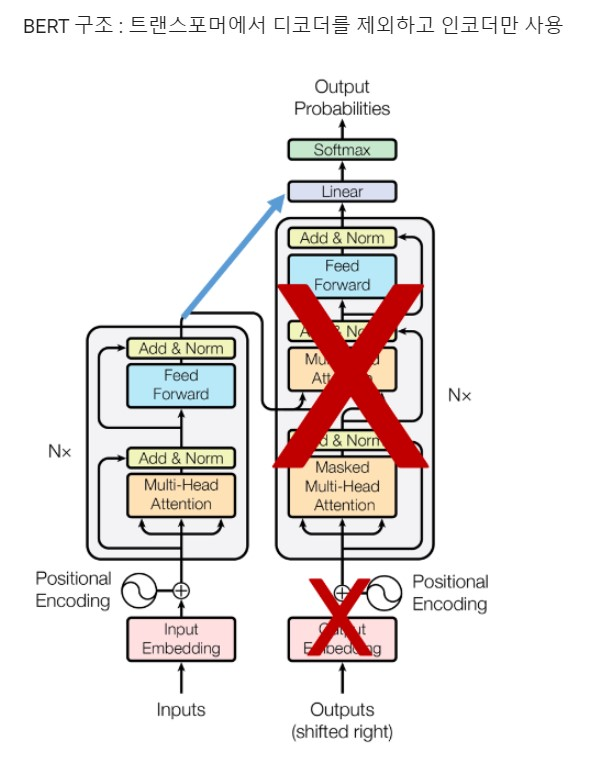

In [3]:
from IPython.display import Image
Image('/content/drive/MyDrive/kdt_240424/m7_nlp응용/data/bert.jpg',width=800,height=800)

## GPT (Generative Pretrained Transformer)
- 트랜스포머 아키텍처의 디코더만 사용하는데, 그 이유는 GPT의 목표와 학습 방식에 기인.
- GPT는 주어진 문맥에 따라 텍스트를 생성하는 것을 목표로 하며 주어진 입력에 대해 가장 가능성 있는 다음 토큰(일반적으로 단어 또는 단어의 일부)을 예측하는 문제로 볼 수 있다.
- 입력 텍스트를 디코더에 직접 제공하고, 디코더는 각 단계에서 다음 토큰을 예측하게 되어 GPT는 주어진 문맥을 기반으로 텍스트를 생성하는 데 필요한 모델을 학습

#### GPT 토큰화 방법
- GPT(Generative Pretrained Transformer)는 토큰화를 위해 Byte-Pair Encoding(BPE)라는 방법을 사용
- BPE는 원래의 텍스트에서 가장 빈번하게 등장하는 문자열 조합을 찾아서 하나의 새로운 '단어'를 만드는 과정을 반복적으로 수행하여 자주 등장하는 단어는 하나의 토큰으로 묶이고, 그렇지 않은 단어는 여러 개의 토큰으로 분리
- 예를 들어 'lowest'라는 단어가 자주 등장하지 않고, 'low'라는 단어와 'est'라는 문자열이 자주 등장한다면, BPE는 'lowest'를 'low'와 'est' 두 개의 토큰으로 분리.
- 이런 방식으로 BPE는 텍스트를 더 작은 단위로 토큰화할 수 있으며, 이는 GPT와 같은 트랜스포머 기반 모델이 문맥을 보다 정확하게 이해하고, 더 큰 어휘를 처리


#### GPT 학습방법
- 사전 학습 (Pre-training): 이 단계에서 GPT는 대량의 텍스트 데이터를 학습하여 언어의 통계적 패턴을 이해. GPT는 이를 위해 'masked language model'이 아닌 'causal language model'을 사용. 즉, 주어진 문장에서 다음에 올 단어를 예측하는 방식으로 학습. 이 때문에 GPT는 문장을 앞에서부터 뒤로 읽으며 학습하게 되므로, 이를 'auto-regressive' 방식이라고 함.

- 파인 튜닝 (Fine-tuning): 사전 학습 후, GPT는 특정 작업에 대해 파인 튜닝될 수 있다. 이 단계에서는 특정 작업(예: 감성 분석, 질문 응답 등)의 학습 데이터를 사용하여 모델을 학습시킵니다. 이때, 모델의 모든 가중치는 업데이트 가능하며, 파인 튜닝을 통해 특정 작업에 대해 최적화됩니다.

- 따라서, GPT의 학습 방법은 사전 학습과 파인 튜닝 두 가지 주요 단계로 구성됩니다. 사전 학습 단계에서는 언어의 일반적인 패턴을 학습하고, 파인 튜닝 단계에서는 이를 바탕으로 특정 작업에 대해 최적화를 진행한다.

- GPT의 원래 목적은 주어진 문맥에서 다음 단어를 예측하는 것이지만, 이런 방식은 기본적으로 언어의 구조와 문맥을 이해하는 능력을 요구. 따라서 이를 바탕으로 모델을 약간 수정하면, 문맥을 이해하고 특정 작업을 수행할 수 있는 모델을 만들 수 있다.
  - 예를 들어, 감성 분석 작업을 수행하기 위해 GPT를 파인 튜닝하는 경우, 모델의 출력 레이어를 각각의 감성 클래스에 대응하는 노드로 대체한 다음, 감성 레이블이 부여된 데이터셋을 사용하여 모델을 학습시키면, GPT는 입력 텍스트의 감성을 분류하는 데 필요한 패턴을 학습하게 된다.

  - 마찬가지로, 질문 응답 시스템을 구축하기 위해 GPT를 파인 튜닝하는 경우, 모델의 입력을 질문과 문맥, 그리고 가능한 답변의 시작과 끝을 나타내는 토큰으로 구성한 다음, 질문과 그에 대한 정답이 포함된 데이터셋을 사용하여 모델을 학습시키면, GPT는 주어진 문맥에서 질문에 대한 적절한 답변을 생성하는 능력을 학습하게 된다.

  따라서, GPT는 언어 생성 모델이지만, 파인 튜닝을 통해 다양한 자연어 처리 작업에 적용할 수 있다. 이는 GPT가 언어의 복잡한 패턴과 구조를 이해하는 능력을 가지고 있기 때문에 가능한 것이다.







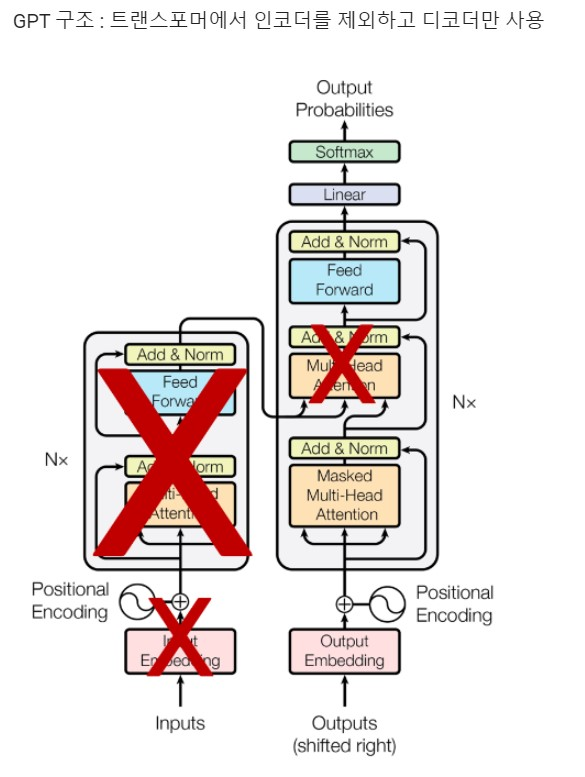

In [5]:
from IPython.display import Image
Image('/content/drive/MyDrive/kdt_240424/m7_nlp응용/data/gpt.jpg',width=800, height=800)